# Importing the necessary python packages

In [1]:
import os
import math
import keras
import shutil
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50, EfficientNetB1
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report

## GPU Check

In [2]:
# Please ensure that the notebook is being run on a GPU, so as to make the training possible, else it would take a lot of time.
!nvidia-smi

Thu Mar 21 19:27:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Setting random seed equals to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Importing and pre-processing the dataset

## Downloading the dataset

In [4]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
!unzip -q real_hst.zip   #Using the dataset by first unzipping it.

Downloading...
From (original): http://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
From (redirected): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx&confirm=t&uuid=9b26da45-babe-46ca-b4b1-5e249727950a
To: /content/real_hst.zip
100% 80.5M/80.5M [00:00<00:00, 184MB/s]


## Splitting the dataset into lensed and non-lensed images folder

In [5]:
# Define the source directory and destination directories
source_dir = '/content/real_hst'
train_dir = '/content/train'
test_dir = '/content/test'
lensed = os.path.join(train_dir, 'lensed')        # Directory for lensed images in training set
non_lensed = os.path.join(train_dir, 'non_lensed')  # Directory for non-lensed images in training set
test_lensed = os.path.join(test_dir, 'lensed')    # Directory for lensed images in test set
test_non_lensed = os.path.join(test_dir, 'non_lensed')  # Directory for non-lensed images in test set

# Ensure destination directories exist, if not, create them
os.makedirs(lensed, exist_ok=True)
os.makedirs(non_lensed, exist_ok=True)
os.makedirs(test_lensed, exist_ok=True)
os.makedirs(test_non_lensed, exist_ok=True)

# Get list of files in the source directory
files = os.listdir(source_dir)
# Shuffle the list to ensure randomness
random.shuffle(files)

# Determine the number of files for training and testing
train_size = int(0.9 * len(files))  # 90% for training, 10% for testing

# Move files to train and test folders
for i, filename in enumerate(files):
    source_file = os.path.join(source_dir, filename)
    if os.path.isfile(source_file):
        if i < train_size:  # Move to train folder
            # Check if the file starts with a number (assumed to be lensed)
            if filename[0].isdigit():
                shutil.move(source_file, os.path.join(lensed, filename))
            # Check if the file starts with 'nl' (assumed to be non-lensed)
            elif filename.startswith('nl'):
                shutil.move(source_file, os.path.join(non_lensed, filename))
        else:  # Move to test folder
            # Check if the file starts with a number (assumed to be lensed)
            if filename[0].isdigit():
                shutil.move(source_file, os.path.join(test_lensed, filename))
            # Check if the file starts with 'nl' (assumed to be non-lensed)
            elif filename.startswith('nl'):
                shutil.move(source_file, os.path.join(test_non_lensed, filename))

print("Files separated successfully!")

Files separated successfully!


## Handling NaN values present in the input data

In [6]:
def replace_nan_with_value(folder_path, replacement_value=0):
    """
    I got the training loss as NaN many times. After debugging it several times, I found that
    there were NaN values in the input itself. I replaced all NaN values with 0 (black),
    as black was the predominant color. To increase accuracy, NaN values could have
    been removed via advanced interpolation techniques.

    Replacing NaN values in NumPy arrays with '0' value.

    Args:
        folder_path (str): Path to the folder containing NumPy files.
        replacement_value (float or int, optional): Value to replace NaN with. Default is 0.

    Returns:
        None
    """
    npy_files = [file for file in os.listdir(folder_path) if file.endswith('.npy')]
    for file in npy_files:
        file_path = os.path.join(folder_path, file)
        array_data = np.load(file_path)
        if np.isnan(array_data).any():
            print(f"Replacing NaN values with {replacement_value} in the array from {file_path}.")
            array_data[np.isnan(array_data)] = replacement_value
            np.save(file_path, array_data)

# Example usage:
folder_paths = [
    '/content/train/non_lensed',
    '/content/test/non_lensed',
    '/content/train/lensed',
    '/content/test/lensed'
]

for folder_path in folder_paths:
    replace_nan_with_value(folder_path)

Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_230_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_286_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_187_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_211_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_150_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_154_hst.npy.
Replacing NaN values with 0 in the array from /content/train/non_lensed/nl_322_hst.npy.
Replacing NaN values with 0 in the array from /content/test/non_lensed/nl_225_hst.npy.
Replacing NaN values with 0 in the array from /content/train/lensed/9369_hst.npy.
Replacing NaN values with 0 in the array from /content/train/lensed/28_hst.npy.
Replacing NaN values with 0 in the array from /content/train/lensed/82_hst.npy.
Replacing NaN values with 0 in the array from /content/

## Plotting the image data

Shape of Lensed: (334, 334)
Shape of Non Lensed: (334, 334)


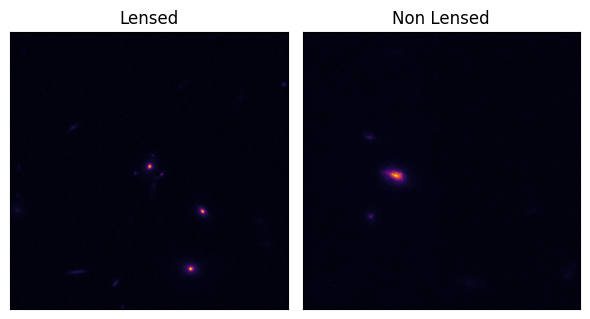

In [7]:
# Create subplots with 1 row and 2 columns, with a figure size of 6x4 inches
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Iterate over the folders containing lensed and non-lensed images
for i, (folder_path, title) in enumerate([
    ('/content/train/lensed', 'Lensed'),
    ('/content/train/non_lensed', 'Non Lensed')]):

    # Get the name of the first file in the folder
    file_name = os.listdir(folder_path)[0]

    # Construct the full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Load the numpy file
    loaded_file = np.load(file_path, allow_pickle=True)

    # Print the shape of the loaded file
    print(f'Shape of {title}: {loaded_file.shape}')

    # Get the image array
    img_array = loaded_file

    # Display the image on the corresponding subplot
    axs[i].imshow(img_array, cmap='inferno')
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()

## Defining parameters

In [8]:
# Algorithm hyperparameters
input_shape = (334, 334, 1)  # Input shape of the images (height, width, channels)
num_epochs = 20  # Number of epochs for training
batch_size = 8  # Batch size used during training

## Splitting the dataset into train and validation data

In [9]:
classes = ['lensed', 'non_lensed']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}

def image_generator(files, label_type, batch_size = batch_size):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = class_indices[class_name]
            input = np.load(input_path, allow_pickle=False)[..., np.newaxis]
            batch_input += [ input ] # For Single channel
            batch_output += [ label ]

        batch_x = np.array(batch_input)
        if label_type == 'one_hot':
            batch_y = to_categorical(batch_output, num_classes=2)  # Perform one-hot encoding
        elif label_type == 'label':
            batch_y = np.array(batch_output)
        # print(batch_x.shape,batch_y.shape)
        yield(batch_x, batch_y)

# Get all file paths in the data_path
data_path = '/content/train'
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]


train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=69)

train_generator_one_hot = image_generator(train_files, label_type = 'one_hot', batch_size=batch_size)
test_generator_one_hot = image_generator(test_files, label_type = 'one_hot', batch_size=batch_size)

train_generator_label = image_generator(train_files,label_type = 'label',  batch_size=batch_size)
test_generator_label = image_generator(test_files,label_type = 'label',  batch_size=batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size


## Generating image and labels

Array Range: 0.0, 109.91007995605469
Sample Image of label lensed: 


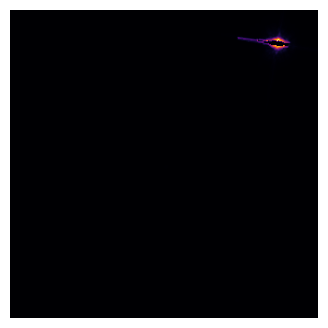

Image shape: (8, 334, 334, 1)
Label shape: (8, 2)


In [10]:
# Generate a sample batch of images and labels from the training generator
image_sample, label_sample = next(train_generator_one_hot)

# Print the range of values in the image array
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')

# Determine the label of the sample image and display it
label = "lensed" if np.argmax(label_sample[0]) == 0 else "non_lensed"
print(f'Sample Image of label {label}: ')
plt.figure(figsize=(4, 4))
plt.imshow(image_sample[0][:, :, 0], cmap='inferno')  # Convert to grayscale and apply colormap
plt.axis('off')
plt.show()

# Print the shapes of the image and label arrays
print(f'Image shape: {image_sample.shape}\nLabel shape: {label_sample.shape}')

# Defining Auto encoder-decoder model

## Defining hyperparameters for the models

In [11]:
width = 128  # Width parameter for contrastive loss function
temperature = 0.1  # Temperature parameter for contrastive loss function
queue_size = 10000  # Size of the queue used in the contrastive loss function

# Data augmentation configuration for contrastive learning with rotation

contrastive_augmentation_gaussian = {
     "std_dev": 0.01,
     "name": "contrastive_augmenter_gaussian"
}

## Defining Utility Functions

In [12]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images

class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images



def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images

## Visualizing the augmentations

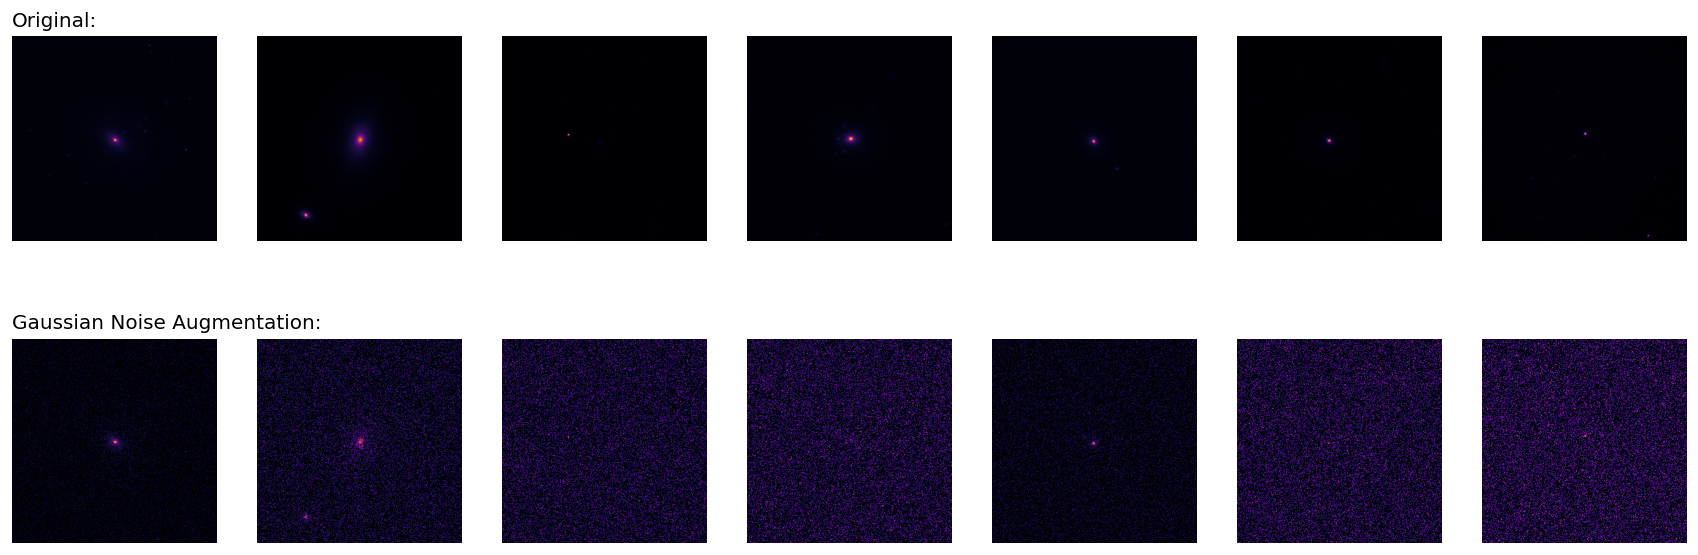

In [13]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images, labels = next(train_generator_one_hot)
    images = images[:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(2, num_images, row * num_images + column + 1)
            plt.imshow(image, cmap='inferno') #np.mean(image, axis=2)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)


# Baseline Model Training


## Defining the encoder

In [14]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
          layers.Dense(width*8,  activation='relu'), #256*8 = 2048
          layers.BatchNormalization(),
          layers.Dropout(0.5),

          layers.Dense(width*4,  activation='relu'), #256*4 = 1024
          layers.BatchNormalization(),
          layers.Dropout(0.5),

          layers.Dense(width,  activation='relu'), #512
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model

## Running the epochs on the model

In [15]:
# Define the baseline model using the encoder architecture and a sigmoid output layer for binary classification
baseline_model = keras.Sequential(
    [
        get_encoder(),  # Encoder model
        layers.Dense(2, activation='sigmoid'),  # Output layer with sigmoid activation for binary classification
    ],
    name="baseline_model",
)

# Compile the baseline model with Adam optimizer, BinaryCrossentropy loss, and evaluation metrics
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Adam optimizer with specified learning rate
    loss=keras.losses.BinaryCrossentropy(),  # BinaryCrossentropy loss for binary classification
    metrics=['acc', metrics.AUC(name='auc')]  # Accuracy and AUC metrics for evaluation
)

# Train the baseline model using the training generator and validate using the test generator
baseline_history = baseline_model.fit(
    train_generator_one_hot,  # Using the generator for training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Number of epochs for training
    validation_data=test_generator_one_hot,  # Using the generator for validation data
    validation_steps=validation_steps  # Number of steps per validation epoch
)

# Print maximal validation accuracy achieved during training
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
21/21 [==============================] - 59s 280ms/step - loss: 0.9383 - acc: 0.5417 - auc: 0.5168 - val_loss: 0.6892 - val_acc: 0.5625 - val_auc: 0.5625
Epoch 2/20
21/21 [==============================] - 4s 213ms/step - loss: 0.8264 - acc: 0.5952 - auc: 0.6280 - val_loss: 0.6400 - val_acc: 0.6875 - val_auc: 0.6875
Epoch 3/20
21/21 [==============================] - 5s 217ms/step - loss: 0.8136 - acc: 0.6012 - auc: 0.6378 - val_loss: 0.7175 - val_acc: 0.5625 - val_auc: 0.5625
Epoch 4/20
21/21 [==============================] - 4s 213ms/step - loss: 0.7655 - acc: 0.6429 - auc: 0.6753 - val_loss: 0.5232 - val_acc: 0.8125 - val_auc: 0.8125
Epoch 5/20
21/21 [==============================] - 5s 215ms/step - loss: 0.9033 - acc: 0.6071 - auc: 0.6125 - val_loss: 0.7011 - val_acc: 0.6250 - val_auc: 0.6250
Epoch 6/20
21/21 [==============================] - 5s 218ms/step - loss: 0.8897 - acc: 0.5893 - auc: 0.5884 - val_loss: 0.7022 - val_acc: 0.6250 - val_auc: 0.6250
Epoch 7/20
21/2

## Saving the weights for baseline model

In [16]:
# Save the weights of the baseline model to a file
baseline_model.save_weights('baseline_model_resnet50.h5')

# Save the training history of the baseline model to a file using pickle
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

# Self-Supervised Contrastive Pretraining

c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the model is able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

## Gauss Blur Augementation

In [46]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )

        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history_gaussian.history["val_p_acc"]) * 100
    )
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 11, 11, 2048)      23581440  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_9 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)              

## Saving weights for pretraining model

In [47]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)

# Fine-tuned model using gaussian blur augmentations

In [48]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(2, activation='softmax'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),  # binary crossentropy
    metrics=['acc', keras.metrics.AUC(name='auc')]
)

finetuning_history_gaussian = finetuning_model_gaussian.fit(
    train_generator_one_hot,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=test_generator_one_hot,
    validation_steps=validation_steps
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_gaussian.history["val_acc"]) * 100
    )
)


Epoch 1/20
21/21 [==============================] - 39s 352ms/step - loss: 0.8831 - acc: 0.5417 - auc: 0.5303 - val_loss: 3.6485 - val_acc: 0.1250 - val_auc: 0.1328
Epoch 2/20
21/21 [==============================] - 5s 232ms/step - loss: 0.8206 - acc: 0.6131 - auc: 0.6124 - val_loss: 1.4582 - val_acc: 0.6250 - val_auc: 0.5156
Epoch 3/20
21/21 [==============================] - 5s 220ms/step - loss: 0.8211 - acc: 0.5536 - auc: 0.5783 - val_loss: 0.6225 - val_acc: 0.6875 - val_auc: 0.6758
Epoch 4/20
21/21 [==============================] - 5s 222ms/step - loss: 0.8952 - acc: 0.5298 - auc: 0.5380 - val_loss: 0.6972 - val_acc: 0.8125 - val_auc: 0.8633
Epoch 5/20
21/21 [==============================] - 5s 226ms/step - loss: 0.7815 - acc: 0.6071 - auc: 0.6278 - val_loss: 0.6280 - val_acc: 0.7500 - val_auc: 0.7539
Epoch 6/20
21/21 [==============================] - 5s 222ms/step - loss: 0.7690 - acc: 0.6369 - auc: 0.6587 - val_loss: 0.6569 - val_acc: 0.6250 - val_auc: 0.7656
Epoch 7/20
21/2

In [49]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)

# Results

In [50]:
with open("baseline_history_resnet50.pkl", "rb") as f:
    baseline_history = pickle.load(f)
with open("finetuning_history_gaussian.pkl", "rb") as f:
    finetuning_history_gaussian = pickle.load(f)

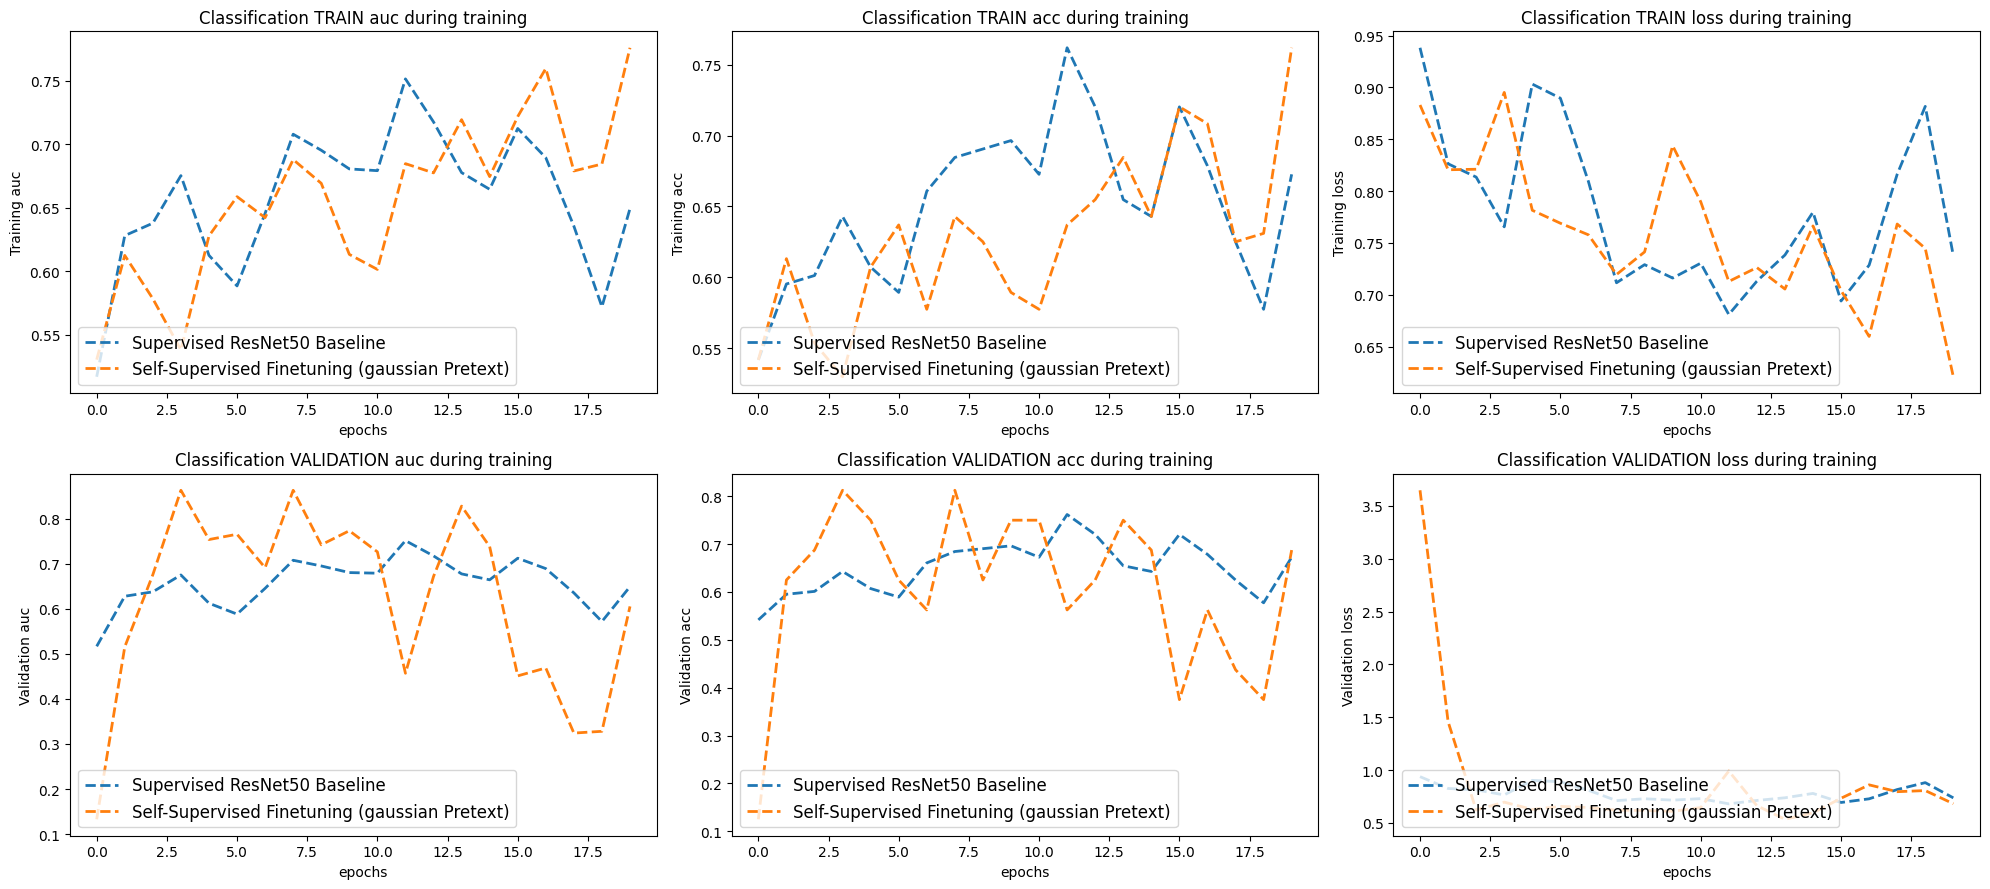

In [51]:
def plot_training_curves(baseline_history, finetuning_history_gaussian):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)

    metric_keys = ["auc", "acc", "loss"]
    metric_names = ["auc", "acc", "loss"]

    # Plotting for training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_gaussian[f"{metric_key}"], label="Self-Supervised Finetuning (gaussian Pretext)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large', loc='lower left')
        axes[0,i].set_title(f"Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_gaussian[f"val_{metric_key}"], label="Self-Supervised Finetuning (gaussian Pretext)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large', loc='lower left')
        axes[1,i].set_title(f"Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")

    plt.tight_layout()
    plt.show()

plot_training_curves(baseline_history, finetuning_history_gaussian)

In [52]:
baseline_model.load_weights('baseline_model_resnet50.h5')
finetuning_model_gaussian.load_weights('finetuning_model_gaussian.h5')

## Validating the model

In [53]:
val_file_paths = []
for class_name in classes:
    val_class_dir = os.path.join('/content/test/' , class_name)
    val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]
val_generator = image_generator(val_file_paths, label_type='one_hot', batch_size = batch_size)

In [54]:
num_batches = len(val_file_paths) // batch_size

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

1/1 [==============================] - 0s 41ms/step


## Classification Report for Model

In [55]:
# Convert one hot encoded labels back to single integer labels for accuracy and classification report
y_true_baseline_int = np.argmax(y_true_baseline, axis=1)
y_pred_baseline_int = np.argmax(y_pred_baseline, axis=1)
y_true_finetuning_gaussian_int = np.argmax(y_true_finetuning_gaussian, axis=1)
y_pred_finetuning_gaussian_int = np.argmax(y_pred_finetuning_gaussian, axis=1)

# Calculate AUC
auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
auc_finetuning_gaussian = roc_auc_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, average='macro', multi_class='ovr')

print("Separate test set results (Containing 5000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")
print(f"AUC (Finetuning gaussian): {int(auc_finetuning_gaussian * 1000) / 1000}")

# Calculate accuracy
accuracy_baseline = accuracy_score(y_true_baseline_int, y_pred_baseline_int)
accuracy_finetuning_gaussian = accuracy_score(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int)

# Print classification report
print("\nClassification Report (Baseline):")
print(classification_report(y_true_baseline_int, y_pred_baseline_int))
print("\nClassification Report (Finetuning gaussian):")
print(classification_report(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int))

Separate test set results (Containing 5000 samples per class):

AUC (Baseline): 1.0
AUC (Finetuning gaussian): 0.909

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.00      0.00      0.00         2

    accuracy                           0.92        24
   macro avg       0.46      0.50      0.48        24
weighted avg       0.84      0.92      0.88        24


Classification Report (Finetuning gaussian):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.33      1.00      0.50         2

    accuracy                           0.83        24
   macro avg       0.67      0.91      0.70        24
weighted avg       0.94      0.83      0.87        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plotting the ROC-AUC Curve for the Model

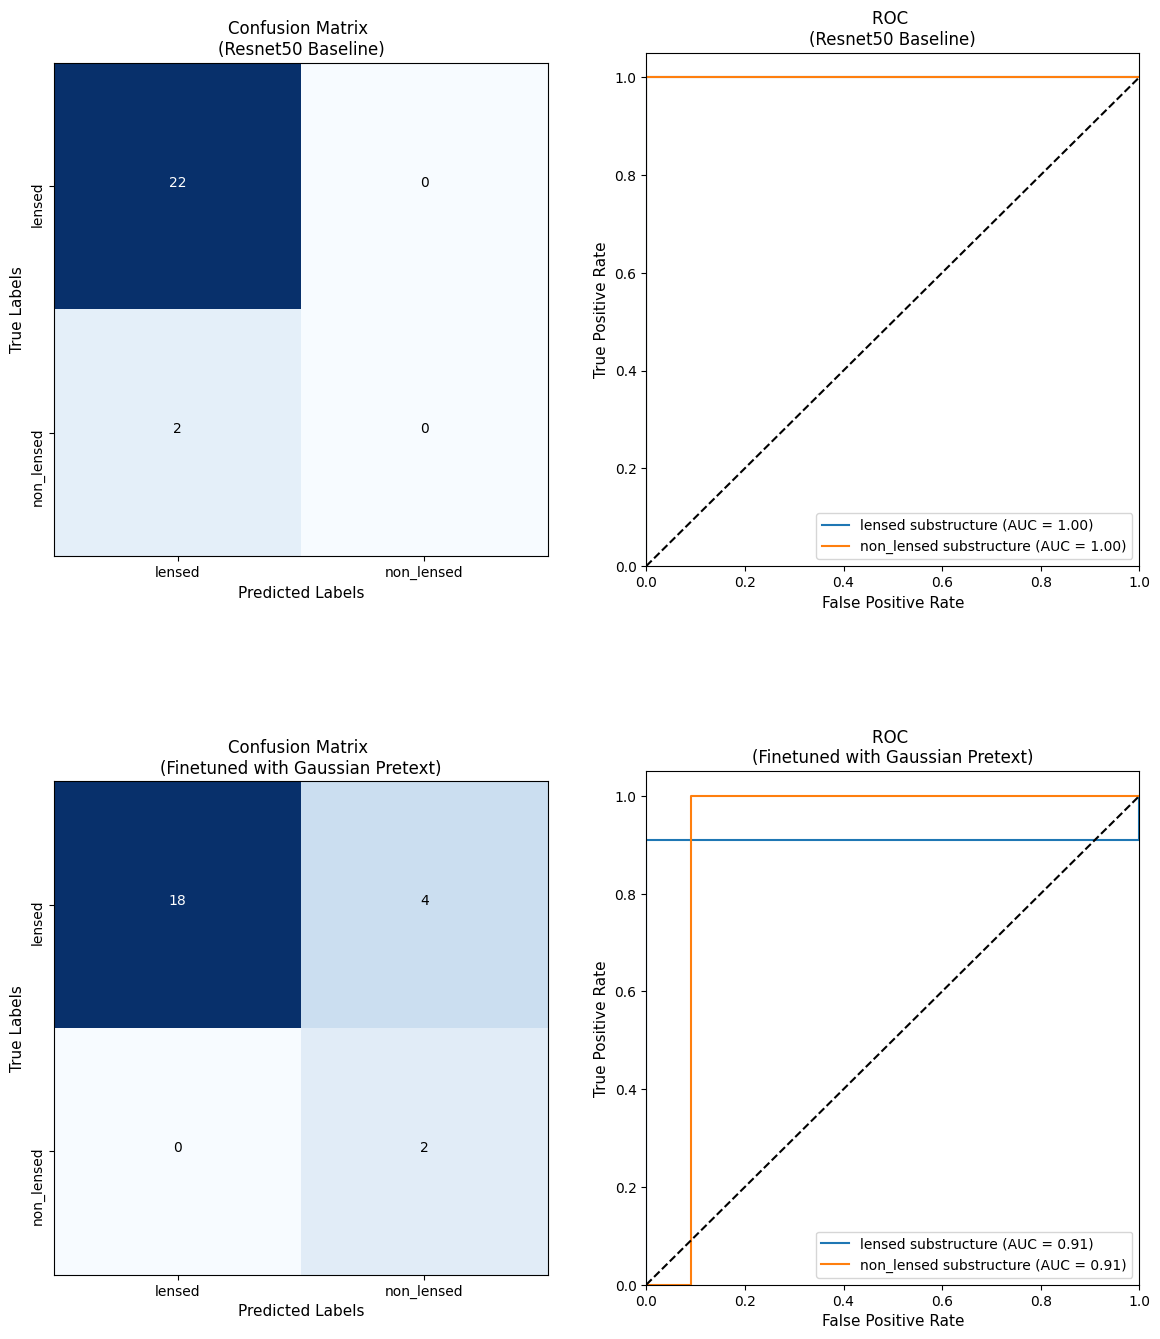

In [56]:
datasets = {
    "Resnet50 Baseline": (y_true_baseline, y_pred_baseline),
    "Finetuned with Gaussian Pretext": (y_true_finetuning_gaussian, y_pred_finetuning_gaussian),
}

plt.figure(figsize=(14, 16))
for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.subplot(len(datasets), 2, 2*idx+1)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix \n({title})', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=11)
    plt.ylabel('True Labels', fontsize=11)

    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, class_indices)
    plt.yticks(tick_marks, class_indices, rotation=90)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.subplot(len(datasets), 2, 2*idx+2)
    for class_name, i in class_indices.items():
        plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC \n({title})', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()
